In [44]:

import os
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Data Exploration

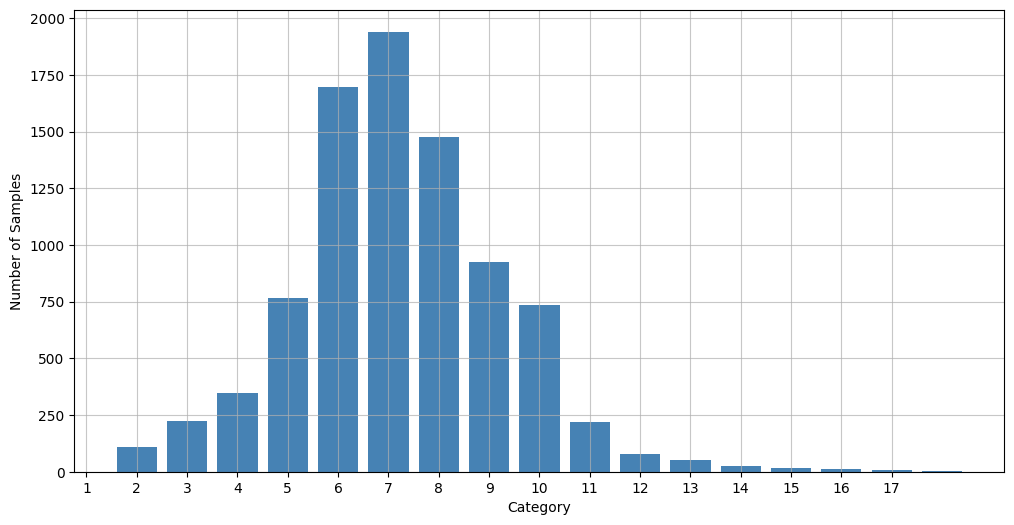

In [18]:
def count_samples_in_categories(base_dir):
    """Count samples in each numbered category folder"""
    categories = []
    counts = []
    
    # Get all subdirectories
    subdirs = sorted([d for d in os.listdir(base_dir) 
                     if os.path.isdir(os.path.join(base_dir, d))],
                    key=lambda x: int(x) if x.isdigit() else 0)
    
    for subdir in subdirs:
        if subdir.isdigit():  # Only process numbered directories
            path = os.path.join(base_dir, subdir)
            # Count files in this directory
            file_count = len([f for f in os.listdir(path) 
                            if os.path.isfile(os.path.join(path, f))])
            categories.append(int(subdir))
            counts.append(file_count)
    
    return categories, counts

cat_count = count_samples_in_categories("../otolith_images")

categories = cat_count[0]
counts = cat_count[1]
x_pos = range(len(categories))


plt.figure(figsize=(12, 6))
plt.bar(categories, counts, 
        color = "steelblue")

plt.grid(alpha = 0.7, linestyle = "-")

# Set categorical labels
plt.xticks(x_pos, categories)
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.grid(alpha=0.7, linestyle="-")
plt.show()

# Train and Evaluate Split

In [36]:
from src.data import DataSplit, create_train_val_test_splits
from src.evaluation import compute_classification_metrics, aggregate_fold_results
from scripts.train_shallow_classifier import run_single_experiment
import tqdm

def load_embeddings(path):
    data = np.load(path)
    return data["features"], data["labels"]

In [37]:
features, labels = load_embeddings("../outputs/embeddings/siglip2-so400m-14-384_embeddings.npz")


splits = create_train_val_test_splits(
        labels=labels,
        n_experiments=1,
        train_ratio=0.8,
        val_ratio=0.1,
        test_ratio=0.1,
        random_state=42,
    )

all_results = []
test_metrics_list = []

for split in tqdm(splits, desc="Experiments"):
    result = run_single_experiment(
        features=features,
        labels=labels,
        split=split,
        alpha_range=alpha_range,
        cv_folds=args.cv_folds,
        n_jobs=args.n_jobs,
    )
    all_results.append(result)
    test_metrics_list.append(result["test_metrics"])

TypeError: 'module' object is not callable

Data shape: (8637, 1152)
Labels shape: (8637,)
Classes: [ 1  2  3  4  5  6  7  8  9 10]

Train: 7773 samples
Test:  864 samples

Running GridSearchCV...


/opt/miniconda3/envs/oto-cod-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/oto-cod-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/oto-cod-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/oto-cod-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/oto-cod-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/oto-cod-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/oto-cod-env/lib/python3.9/site-packages/skle

Best alpha: 0.108
Best CV MSE: 0.9346

TEST SET RESULTS
Accuracy:      43.98%
±1 Accuracy:   91.20%
F1-Score:      33.60%
RMSE:          0.924


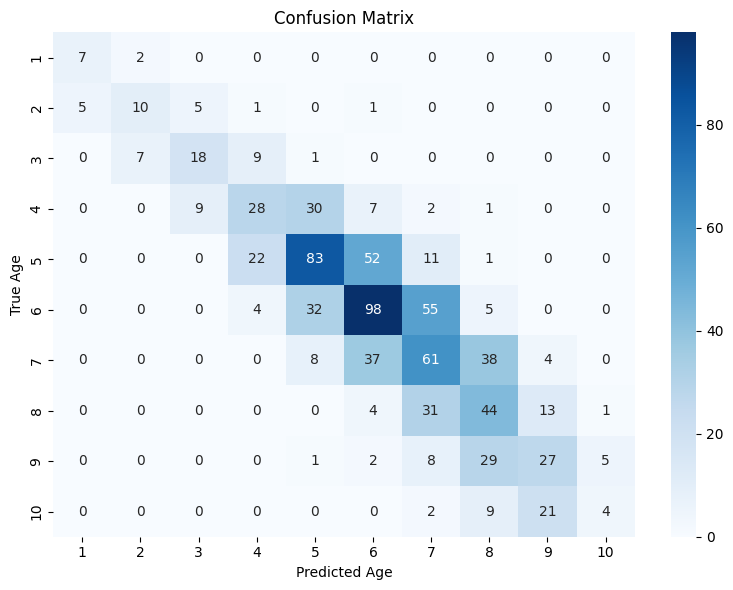


PER-CLASS PERFORMANCE
              precision    recall  f1-score   support

           1       0.58      0.64      0.61        11
           2       0.53      0.45      0.49        22
           3       0.56      0.51      0.54        35
           4       0.44      0.36      0.40        77
           5       0.54      0.49      0.51       169
           6       0.49      0.51      0.50       194
           7       0.36      0.41      0.38       148
           8       0.35      0.47      0.40        93
           9       0.42      0.36      0.39        74
          10       0.40      0.10      0.16        41

   micro avg       0.44      0.44      0.44       864
   macro avg       0.47      0.43      0.44       864
weighted avg       0.45      0.44      0.44       864


ERROR DISTRIBUTION
Perfect predictions (error=0): 380 (44.0%)
Off by 1:                      408 (47.2%)
Off by 2:                      66 (7.6%)
Off by 3+:                     10 (1.2%)

LARGEST ERRORS (n=76)
     tr

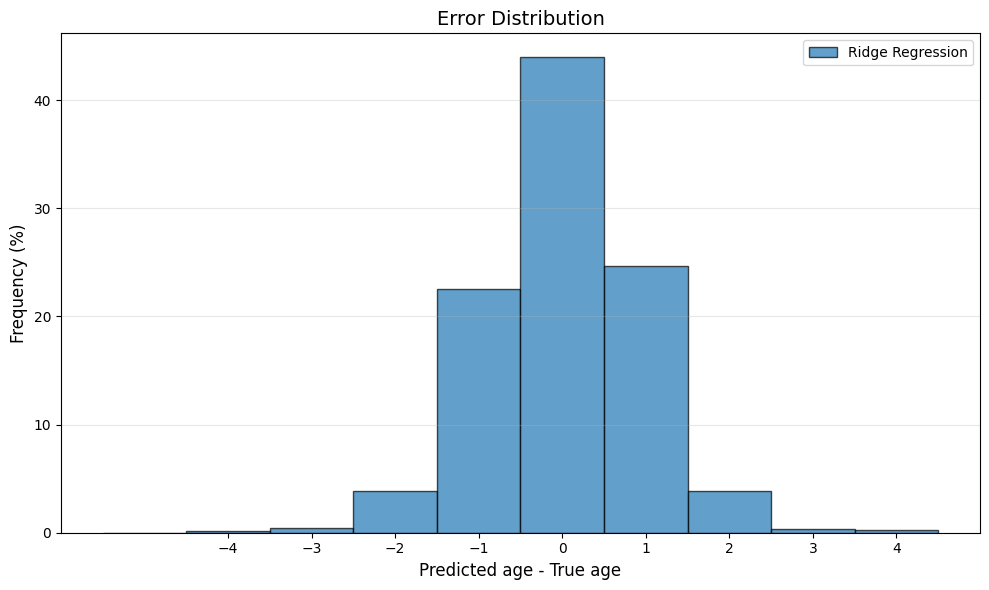


Error Distribution:
Error -4:   0.1%
Error -3:   0.5%
Error -2:   3.8%
Error -1:  22.6%
Error +0:  44.0%
Error +1:  24.7%
Error +2:   3.8%
Error +3:   0.3%
Error +4:   0.2%


In [52]:
# Simple Ridge Classifier Experiment - Single Run
# For exploring where the model underperforms

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# 1. LOAD DATA
# ============================================================================

embeddings_path = "../outputs/embeddings/siglip2-so400m-14-384_embeddings.npz"
data = np.load(embeddings_path)
features = data["features"]
labels = data["labels"]
data.close()

# Filter to target ages
target_ages = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mask = np.isin(labels, target_ages)
features = features[mask]
labels = labels[mask]

print(f"Data shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Classes: {np.unique(labels)}")

# ============================================================================
# 2. TRAIN/VAL/TEST SPLIT
# ============================================================================

from sklearn.model_selection import train_test_split

# First split: 80% train+val, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, stratify=labels, random_state=42
)

print(f"\nTrain: {len(X_train)} samples")
print(f"Test:  {len(X_test)} samples")

# ============================================================================
# 3. GRID SEARCH WITH CROSS-VALIDATION
# ============================================================================

# Compute sample weights for class balancing
sample_weights = compute_sample_weight("balanced", y_train)

# Define parameter grid
alpha_range = np.linspace(0.01, 19.6, 200)

# Setup GridSearchCV
clf = Ridge(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    clf,
    param_grid={"alpha": alpha_range},
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    return_train_score=True
)

print("\nRunning GridSearchCV...")
grid_search.fit(X_train, y_train, sample_weight=sample_weights)

print(f"Best alpha: {grid_search.best_params_['alpha']:.3f}")
print(f"Best CV MSE: {-grid_search.best_score_:.4f}")

# ============================================================================
# 4. EVALUATE ON TEST SET
# ============================================================================

best_model = grid_search.best_estimator_

# Make predictions (round for classification)
y_test_pred = np.round(best_model.predict(X_test)).astype(int)

# Compute metrics
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

accuracy = accuracy_score(y_test, y_test_pred)
accuracy_pm1 = np.mean(np.abs(y_test - y_test_pred) <= 1)
f1 = f1_score(y_test, y_test_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))

print(f"\n{'='*50}")
print("TEST SET RESULTS")
print(f"{'='*50}")
print(f"Accuracy:      {accuracy*100:.2f}%")
print(f"±1 Accuracy:   {accuracy_pm1*100:.2f}%")
print(f"F1-Score:      {f1*100:.2f}%")
print(f"RMSE:          {rmse:.3f}")

# ============================================================================
# 5. ANALYZE ERRORS - WHERE DOES THE MODEL STRUGGLE?
# ============================================================================

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=target_ages)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_ages, yticklabels=target_ages)
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Per-class performance
print(f"\n{'='*50}")
print("PER-CLASS PERFORMANCE")
print(f"{'='*50}")
print(classification_report(y_test, y_test_pred, labels=target_ages))

# Find worst predictions
errors = np.abs(y_test - y_test_pred)
error_df = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'error': errors
})

print(f"\n{'='*50}")
print("ERROR DISTRIBUTION")
print(f"{'='*50}")
print(f"Perfect predictions (error=0): {np.sum(errors == 0)} ({np.sum(errors == 0)/len(errors)*100:.1f}%)")
print(f"Off by 1:                      {np.sum(errors == 1)} ({np.sum(errors == 1)/len(errors)*100:.1f}%)")
print(f"Off by 2:                      {np.sum(errors == 2)} ({np.sum(errors == 2)/len(errors)*100:.1f}%)")
print(f"Off by 3+:                     {np.sum(errors >= 3)} ({np.sum(errors >= 3)/len(errors)*100:.1f}%)")

# Show examples of large errors
large_errors = error_df[error_df['error'] >= 2].sort_values('error', ascending=False)
print(f"\n{'='*50}")
print(f"LARGEST ERRORS (n={len(large_errors)})")
print(f"{'='*50}")
print(large_errors.head(20))

# Class-wise error analysis
print(f"\n{'='*50}")
print("AVERAGE ERROR BY TRUE AGE")
print(f"{'='*50}")
age_error_summary = error_df.groupby('true_age').agg({
    'error': ['mean', 'std', 'count']
}).round(3)
print(age_error_summary)


#####
## Error distribution histogram
#####

# Error distribution histogram with percentage
plt.figure(figsize=(10, 6))

# Calculate error (predicted - true)
error_signed = y_test_pred - y_test

# Create histogram with percentage
bins = np.arange(-5, 6) - 0.5  # Center bins on integers
counts, _, _ = plt.hist(error_signed, bins=bins, alpha=0.7, edgecolor='black', 
                        weights=np.ones(len(error_signed)) / len(error_signed) * 100,
                        label='Ridge Regression')

plt.xlabel('Predicted age - True age', fontsize=12)
plt.ylabel('Frequency (%)', fontsize=12)
plt.title('Error Distribution', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.xticks(range(-4, 5))
plt.tight_layout()
plt.show()

# Print percentages for each error value
print(f"\nError Distribution:")
for error_val in range(-4, 5):
    pct = np.sum(error_signed == error_val) / len(error_signed) * 100
    print(f"Error {error_val:+2d}: {pct:5.1f}%")


# Temp

In [96]:
import pandas as pd

df = pd.read_csv("../cod_otolith_age_final.csv")

df_complete = pd.read_csv("/Users/joaodsm/Desktop/Joao Workspace/PhD Compilation/otolith-project/Data/cod_otolith_age_cleaned.csv")

df

#df_complete

,measurement_id,sample_id_x,station_id,cruise_id,age,length,weight,sex_number,maturity_number,gutted_weight,liver_weight,gonad_weight,area_grid,sub_area_grid,shot_latitude,shot_longitude,gsi,hsi,bounding_box,image__content__url
0,21514156,507573,322736,18797,14.0,108,9550.0,1.0,3.0,8050.0,431.0,538.0,366,4,63.722833,-16.495333,5.633508,4.513089,"[[0, 0], [8256, 5504]]",https://prod-photolith-s3-civil-hyena.s3.amazo...
1,23252819,536991,338642,20516,1.0,12,13.0,NaN,NaN,NaN,NaN,NaN,671,3,66.602500,-21.908667,NaN,NaN,"[[1868, 974], [2428, 1361]]",https://prod-photolith-s3-civil-hyena.s3.amazo...
2,23252811,536991,338642,20516,4.0,48,1225.0,2.0,1.0,936.0,26.0,NaN,671,3,66.602500,-21.908667,NaN,2.122449,"[[1063, 765], [1820, 1391]]",https://prod-photolith-s3-civil-hyena.s3.amazo...
3,23252809,536991,338642,20516,5.0,58,2102.0,2.0,1.0,1600.0,35.0,NaN,671,3,66.602500,-21.908667,NaN,1.665081,"[[5772, 75], [6834, 704]]",https://prod-photolith-s3-civil-hyena.s3.amazo...
4,23252717,536991,338642,20516,5.0,60,1949.0,1.0,1.0,1623.0,24.0,NaN,671,3,66.602500,-21.908667,NaN,1.231401,"[[1075, 0], [1943, 630]]",https://prod-photolith-s3-civil-hyena.s3.amazo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8633,24922863,555450,348917,20746,7.0,70,2985.0,2.0,1.0,2368.0,141.0,NaN,671,4,66.648833,-21.449833,NaN,4.723618,"[[1370, 3758], [2432, 4387]]",https://prod-photolith-s3-civil-hyena.s3.amazo...
8634,24922866,555450,348917,20746,6.0,66,2800.0,2.0,1.0,2260.0,289.0,NaN,671,4,66.648833,-21.449833,NaN,10.321429,"[[2518, 3774], [3579, 4403]]",https://prod-photolith-s3-civil-hyena.s3.amazo...
8635,24922867,555450,348917,20746,6.0,50,1257.0,2.0,1.0,1064.0,139.0,NaN,671,4,66.648833,-21.449833,NaN,11.058075,"[[3745, 3823], [4762, 4356]]",https://prod-photolith-s3-civil-hyena.s3.amazo...
8636,24922869,555450,348917,20746,6.0,63,2220.0,2.0,1.0,1850.0,226.0,NaN,671,4,66.648833,-21.449833,NaN,10.180180,"[[5881, 3759], [6815, 4276]]",https://prod-photolith-s3-civil-hyena.s3.amazo...


In [117]:
(df_complete.isnull().mean() * 100).round(2)

df_complete = df_complete[df_complete["measurement_id"].isin(df["measurement_id"])]

df_complete = df_complete.drop_duplicates(subset="measurement_id", keep = "first")

df_complete_subset = df_complete[["measurement_id", "month", "length"]].copy()    

df_complete_subset["quarter"] = 1 + (df_complete_subset["month"] - 1) // 3 
df_complete_subset


df_merged = df.merge(
    df_complete_subset[["measurement_id", "quarter"]],
    on="measurement_id",
    how="left"
)

dummies = pd.get_dummies(df_merged, columns=['quarter'], prefix='quarter', drop_first = True)

df_merged = pd.concat([df_merged, dummies[["quarter_2", "quarter_3", "quarter_4"]]], axis=1)

df_merged["quarter_sin"] = np.sin(2 * np.pi * df_merged["quarter"] / 4)
df_merged["quarter_cos"] = np.cos(2 * np.pi * df_merged["quarter"] / 4)

df_merged.to_csv("../cod_otolith_age_final_with_quarters.csv", index = False)
# df_complete["measurement_id"].nunique()


# dupl = df_complete[df_complete.duplicated(subset="measurement_id", keep=False)]

# print(dupl)

In [75]:
# Find duplicated measurement_id rows
dupl = df_complete[df_complete.duplicated(subset="measurement_id", keep=False)]

# Check if all columns are identical for each duplicated measurement_id
dupl_grouped = dupl.groupby("measurement_id")
for mid, group in dupl_grouped:
    identical = group.drop("measurement_id", axis=1).nunique().sum() == 0
    age_labels = group["age"].unique()
    print(f"measurement_id: {mid}")
    print(f"  Rows identical: {identical}")
    print(f"  Age labels: {age_labels}")
    print(f"  Number of duplicates: {len(group)}\n")


dupl_grouped = dupl.groupby("measurement_id")
for mid, group in dupl_grouped:
    # Only check if there is more than one row
    if len(group) > 1:
        # Compare all columns except measurement_id
        cols = [col for col in group.columns if col != "measurement_id"]
        # Check for differences column-wise
        for col in cols:
            unique_vals = group[col].unique()
            if len(unique_vals) > 1:
                print(f"measurement_id: {mid} - Column '{col}' differs: {unique_vals}")

measurement_id: 23253190
  Rows identical: False
  Age labels: [5.]
  Number of duplicates: 2

measurement_id: 23253191
  Rows identical: False
  Age labels: [5.]
  Number of duplicates: 2

measurement_id: 23253192
  Rows identical: False
  Age labels: [4.]
  Number of duplicates: 2

measurement_id: 23253193
  Rows identical: False
  Age labels: [5.]
  Number of duplicates: 2

measurement_id: 23253194
  Rows identical: False
  Age labels: [4.]
  Number of duplicates: 2

measurement_id: 23253195
  Rows identical: False
  Age labels: [6.]
  Number of duplicates: 2

measurement_id: 23253277
  Rows identical: False
  Age labels: [4.]
  Number of duplicates: 2

measurement_id: 23253278
  Rows identical: False
  Age labels: [4.]
  Number of duplicates: 2

measurement_id: 23253280
  Rows identical: False
  Age labels: [5.]
  Number of duplicates: 2

measurement_id: 23253281
  Rows identical: False
  Age labels: [5.]
  Number of duplicates: 2

measurement_id: 23253282
  Rows identical: False
 

In [76]:
# ...existing code...
diff_cols = set()
for mid, group in dupl_grouped:
    if len(group) > 1:
        for col in group.columns:
            if col != "measurement_id" and group[col].nunique() > 1:
                diff_cols.add(col)
print("Columns that differ among duplicates:", diff_cols)
# ...existing code...

Columns that differ among duplicates: {'image__content__url', 'bounding_box'}


In [ ]:
from src.data.dataset import OtolithDataset


 dataset = OtolithDataset(
    root_dir="otolith_images",
    transform=get_clip_preprocess(),
    age_range=(1, 10)
    )



features:
  Shape: (8637, 1152)
  Dtype: float32
  Sample data:
[[ 0.00945484 -0.00165417 -0.00083928 ...  0.00610193  0.00588945
  -0.01035104]
 [ 0.02205553 -0.02179048  0.00663789 ...  0.00284956  0.00282385
  -0.02241079]
 [ 0.00765562 -0.0099874  -0.00775267 ... -0.00241069  0.00561512
  -0.02132116]
 ...
 [ 0.00418779 -0.00995968 -0.01083267 ... -0.01131566  0.00379535
  -0.01092329]
 [ 0.00516385  0.00015634 -0.01772037 ...  0.00873402 -0.00302608
  -0.0169593 ]
 [ 0.00595393 -0.00055557 -0.00422023 ... -0.0042509   0.00527725
  -0.02922298]]

labels:
  Shape: (8637,)
  Dtype: int64
  Sample data:
[1 1 1 ... 9 9 9]
